In [58]:
# Dataset taken from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [59]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [60]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
import numpy as np

In [61]:
torch.cuda.set_device(0)

In [62]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [63]:
import fastai.utils.collect_env; fastai.utils.collect_env.show_install(1)



```text
=== Software === 
python        : 3.6.6
fastai        : 1.0.51
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.9.0-8-amd64-x86_64-with-debian-9.4
distro        : #1 SMP Debian 4.9.144-3.1 (2019-02-19)
conda env     : Unknown
python        : /opt/conda/bin/python
sys.path      : 
/kaggle/lib/kagglegym
/kaggle/lib
/opt/conda/lib/python36.zip
/opt/conda/lib/python3.6
/opt/conda/lib/python3.6/lib-dynload
/root/.local/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages/nolearn-0.6.1.dev0-py3.6.egg
/opt/conda/lib/python3.6/site-packages/tabulate-0.8.3-py3.6.egg
/opt/conda/lib/python3.6/site-packages/gdbn-0.1-py3.6.egg
/opt/conda/lib/python3.6/site-packages/gnumpy-0.2-py3.6.egg
/opt/co

In [64]:
path = Path('../input/cell_images/cell_images'); path

PosixPath('../input/cell_images/cell_images')

In [65]:
path.ls()

[PosixPath('../input/cell_images/cell_images/Uninfected'),
 PosixPath('../input/cell_images/cell_images/Parasitized')]

# Data Exploration

In [66]:
import os

In [67]:
np.random.seed(42)

In [68]:
path_image_parasitized = Path('../input/cell_images/cell_images/Parasitized/')
path_image_uninfected = Path('../input/cell_images/cell_images/Uninfected/')

In [69]:
parasitized_images = get_image_files(path_image_parasitized)[:10]
parasitized_images

[PosixPath('../input/cell_images/cell_images/Parasitized/C99P60ThinF_IMG_20150918_141620_cell_36.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C118P79ThinF_IMG_20151002_105827_cell_130.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C137P98ThinF_IMG_20151005_163712_cell_85.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C124P85ThinF_IMG_20151002_153825_cell_190.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C93P54ThinF_IMG_20150821_163640_cell_196.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_133350_cell_183.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_112119_cell_21.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C133P94ThinF_IMG_20151004_154351_cell_106.png'),
 PosixPath('../input/cell_images/cell_images/Parasitized/C182P143NThinF_IMG_20151201_172257_cell_163.png'),
 PosixPath('../input/cell_images/cell_ima

In [70]:
path_para, dirs, files = next(os.walk(path_image_parasitized))
file_count = len(files)
print("Number of images for parasitized:", file_count)

Number of images for parasitized: 13780


torch.Size([118, 202])

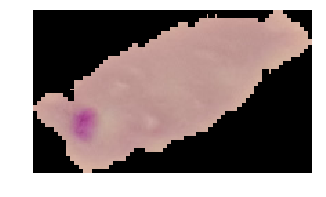

In [71]:
images_para = open_image(parasitized_images[np.random.randint(0, 9)])
images_para.show(figsize=(5,5))
images_para.size

In [72]:
uninfected_images = get_image_files(path_image_uninfected)[:10]
uninfected_images

[PosixPath('../input/cell_images/cell_images/Uninfected/C241NThinF_IMG_20151207_124643_cell_125.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C211ThinF_IMG_20151029_164248_cell_207.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C76P37ThinF_IMG_20150815_172808_cell_170.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C226ThinF_IMG_20151112_131546_cell_172.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C187P148NThinF_IMG_20151203_153036_cell_98.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C65P26N_ThinF_IMG_20150818_154624_cell_41.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C240ThinF_IMG_20151127_115306_cell_6.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C183P144NThinF_IMG_20151201_224458_cell_31.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C180P141NThinF_IMG_20151201_165601_cell_39.png'),
 PosixPath('../input/cell_images/cell_images/Uninfected/C230ThinF_

In [73]:
path_unin, dirs, files = next(os.walk(path_image_uninfected))
file_count = len(files)
print("Number of images for uninfected:", file_count)

Number of images for uninfected: 13780


torch.Size([121, 139])

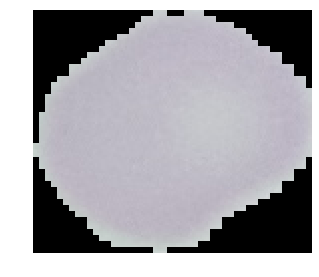

In [74]:
images_unin = open_image(uninfected_images[np.random.randint(0, 9)])
images_unin.show(figsize=(5,5))
images_unin.size

## Observations: 
- Data is evenly balanced in number of images for uninfected and infected
- Images aren't evenly sized.
- I assume purple cells are white blood cells and peach are red blood cells
- Not positive on what ThinF means. I assume it means thin slices of cells
- Unsure what the various versions of ReThinF, NThinF, ThinF, thinF, etc. denotes in the images


# Data Bunching
<input type="checkbox"> Combine uninfected & infected for training set
<input type="checkbox"> Resize images to uniform size


In [75]:
path

PosixPath('../input/cell_images/cell_images')

In [76]:
data = ImageDataBunch.from_folder(path, train=".",
                                  valid_pct=0.2, # Splits the dataset into 80/20% training/validation
                                  ds_tfms=get_transforms(do_flip = True, flip_vert = True, max_warp=0), # AFAIK these types of images can be flipped any direction vertically, horizontally, 90 degrees in actual cell images
                                  size=224,bs=64 # Trying out a larger 256 size at first
                                 ).normalize(imagenet_stats)

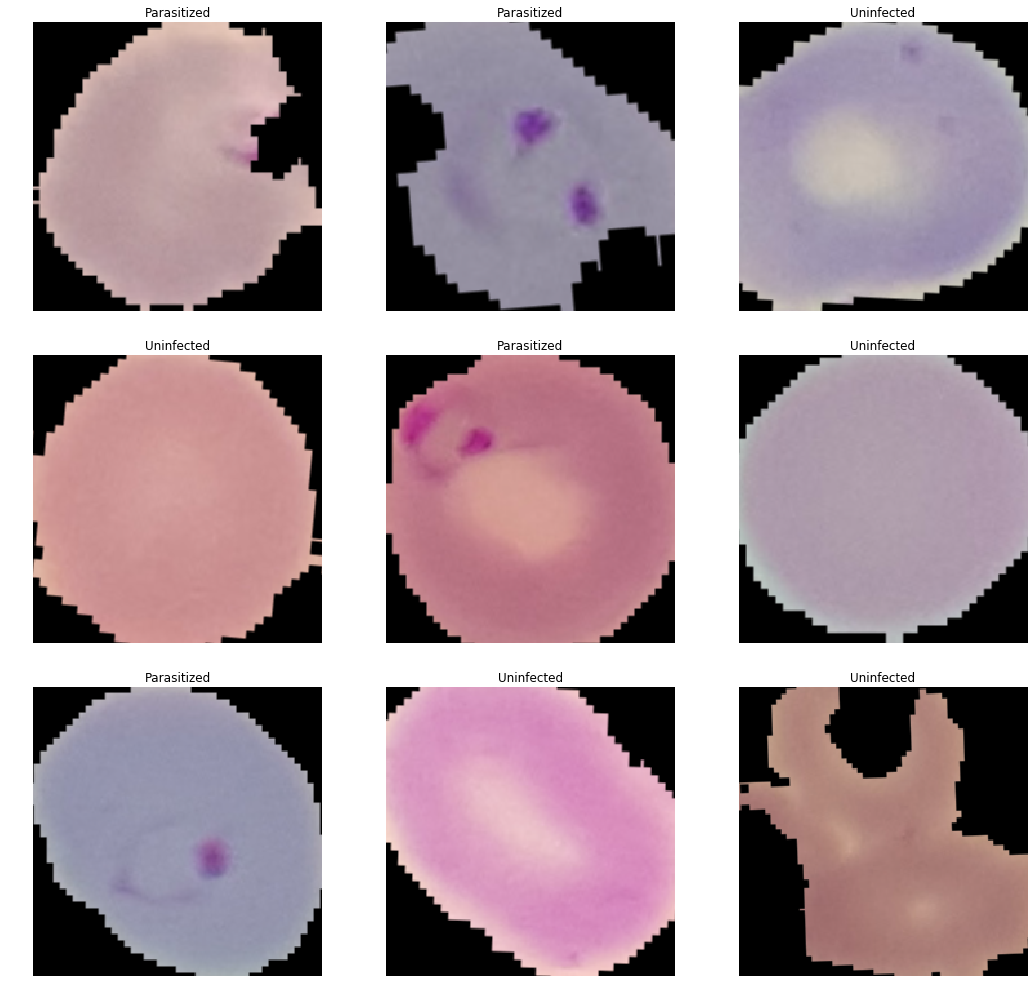

In [77]:
data.show_batch(rows=3, figsize=(15,14))

In [78]:
print(data.classes)
len(data.classes),data.c

['Parasitized', 'Uninfected']


(2, 2)

# Model Training

In [79]:
# Trying out mixed precision learning
# https://docs.fast.ai/callbacks.fp16.html
# https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html
# Update: Did not work. Error: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

learn = cnn_learner(data, models.resnet34, metrics=error_rate, model_dir="/kaggle/model")

In [80]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [81]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.214603,0.152560,0.055707,02:26
1,0.159855,0.120110,0.043368,02:27
2,0.140667,0.109788,0.038287,02:27
3,0.138456,0.107025,0.038106,02:26


In [82]:
learn.save('/kaggle/working/malaria_resnet34_initial_training')

# Examining results of initial training

In [83]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

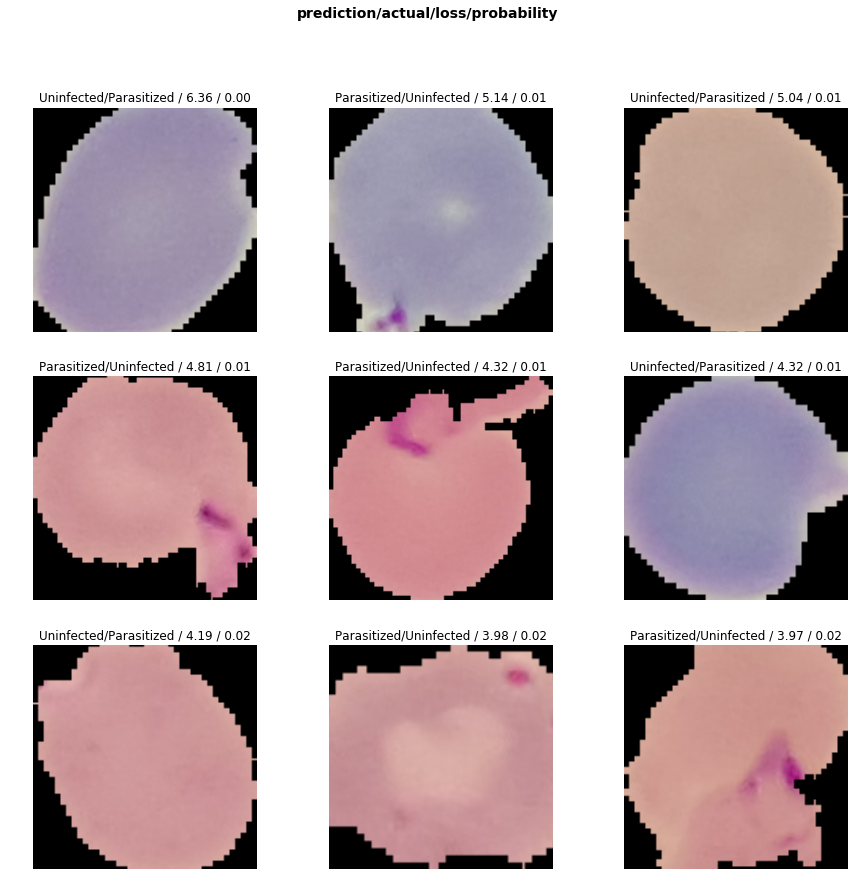

In [84]:
# Note: these are images that are in the top_losses section. Model was not sure what these were 
# TODO: Ask someone with biology background to predict these
interp.plot_top_losses(9, figsize=(15,14),  heatmap = False)

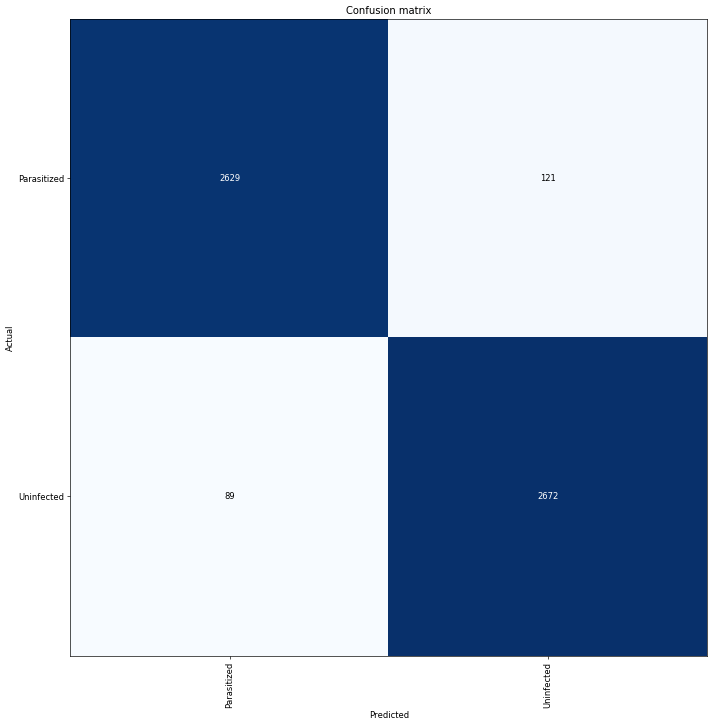

In [85]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Model improvement
<input type="checkbox"> Unfreeze layer 1. All the information gleamed off resnet34 to form basic shapes as I understand it.
<input type="checkbox"> Fine tune learning rate

In [86]:
learn.unfreeze()

In [87]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.127741,0.094307,0.035202,02:32


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


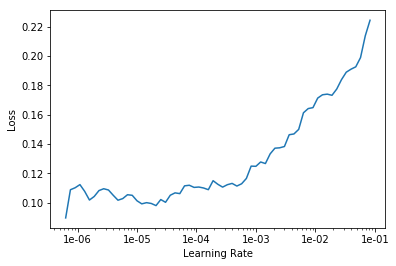

In [88]:
learn.lr_find()
learn.recorder.plot()

In [89]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.118896,0.087729,0.031936,02:33
1,0.108773,0.080746,0.028670,02:33


# Reexamining results
Improvement! 🙌

In [90]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

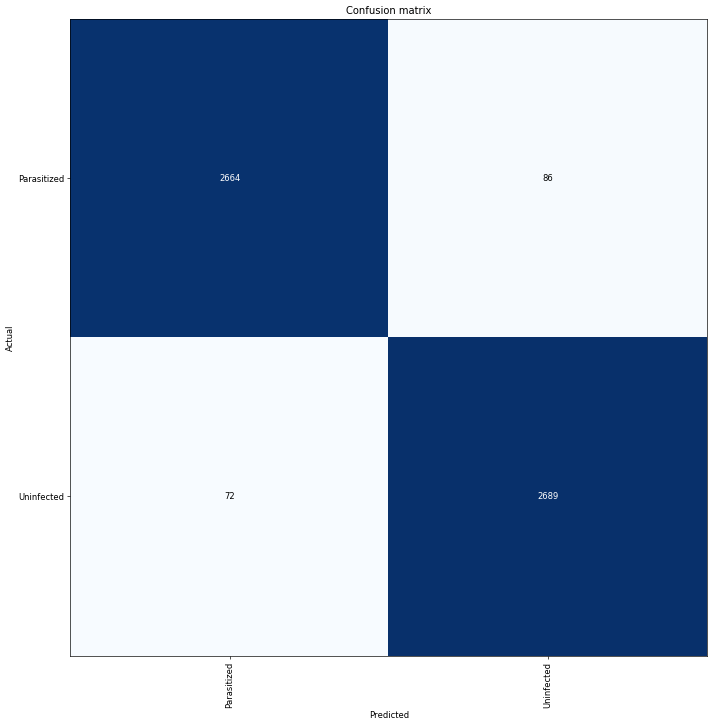

In [91]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [92]:
learn.save('/kaggle/working/malaria_resnet34_unfrozen_and_tuned')

# But 97% accuracy is probably too low for medical diagnosis. I'm guessing they want 99.9% or higher
> <input type="checkbox"> ResNet50

In [93]:
# learn.load('malaria_unfrozen_and_tuned')

In [94]:
data = ImageDataBunch.from_folder(path, train=".",
                                  valid_pct=0.2, # Splits the dataset into 80/20% training/validation
                                  ds_tfms=get_transforms(flip_vert = True), # AFAIK images can be flipped any direction vertically, horizontally, 90 degrees in actual cell images
                                  size=299,bs=32
                                 ).normalize(imagenet_stats)

In [95]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 299, 299])

In [96]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


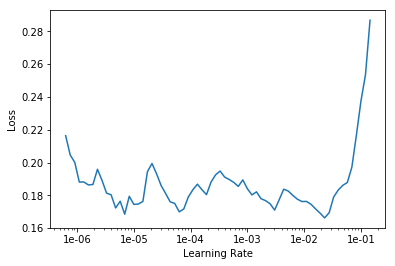

In [97]:
learn.lr_find()
learn.recorder.plot()

In [98]:
learn.fit_one_cycle(10, slice(1e-3/2))

epoch,train_loss,valid_loss,error_rate,time
0,0.139861,0.094441,0.035202,04:40
1,0.147212,0.089716,0.032843,04:42
2,0.116595,0.086270,0.031210,04:39
3,0.105906,0.083397,0.031210,04:43
4,0.108008,0.083266,0.030122,04:42
5,0.115872,0.081980,0.031029,04:43
6,0.101909,0.081097,0.029759,04:42
7,0.108708,0.081687,0.030303,04:45
8,0.102861,0.081585,0.030122,04:44
9,0.116473,0.080469,0.030484,04:43


In [99]:
learn.save('/kaggle/working/malaria_initial_training_resnet50')

In [100]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


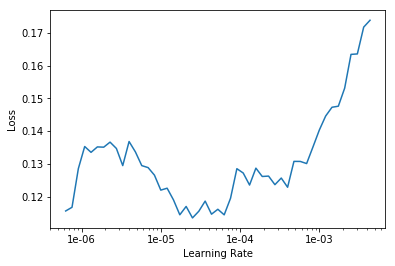

In [101]:
learn.lr_find()
learn.recorder.plot()

In [102]:
learn.fit_one_cycle(5, slice(1e-4, (1e-3)/5))

# learn.fit_one_cycle(8, 3e-3)
# https://youtu.be/ccMHJeQU4Qw?t=3552 ¯\_(ツ)_/¯

epoch,train_loss,valid_loss,error_rate,time
0,0.135995,0.118971,0.038287,04:55
1,0.146061,0.100487,0.034114,04:54
2,0.119559,0.084867,0.031392,04:54
3,0.095427,0.076006,0.028126,04:47
4,0.090667,0.074651,0.027763,04:42


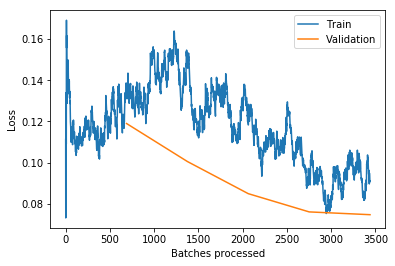

In [103]:
learn.recorder.plot_losses()

In [104]:
learn.save('/kaggle/working/malaria_resnet50_unfrozen_and_tuned')

In [105]:
# Wrongly implemented transfer learning

In [106]:
#learn = cnn_learner(data, models.resnet50, metrics=error_rate, model_dir="/kaggle/model")

In [107]:
# learn.lr_find()
# learn.recorder.plot()

In [108]:
# learn.fit_one_cycle(8, 3e-3)
# https://youtu.be/ccMHJeQU4Qw?t=3552 ¯\_(ツ)_/¯

In [109]:
# learn.save('/kaggle/working/malaria_initial_training_resnet50')

In [110]:
# learn.lr_find()
# learn.recorder.plot()

In [111]:
#TODO: Figure out how many epochs before this starts doing badly. Just starting to get good! Could push a couple more.

# learn.unfreeze()
# learn.fit_one_cycle(15, max_lr=slice(1e-6,1e-4))

In [112]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

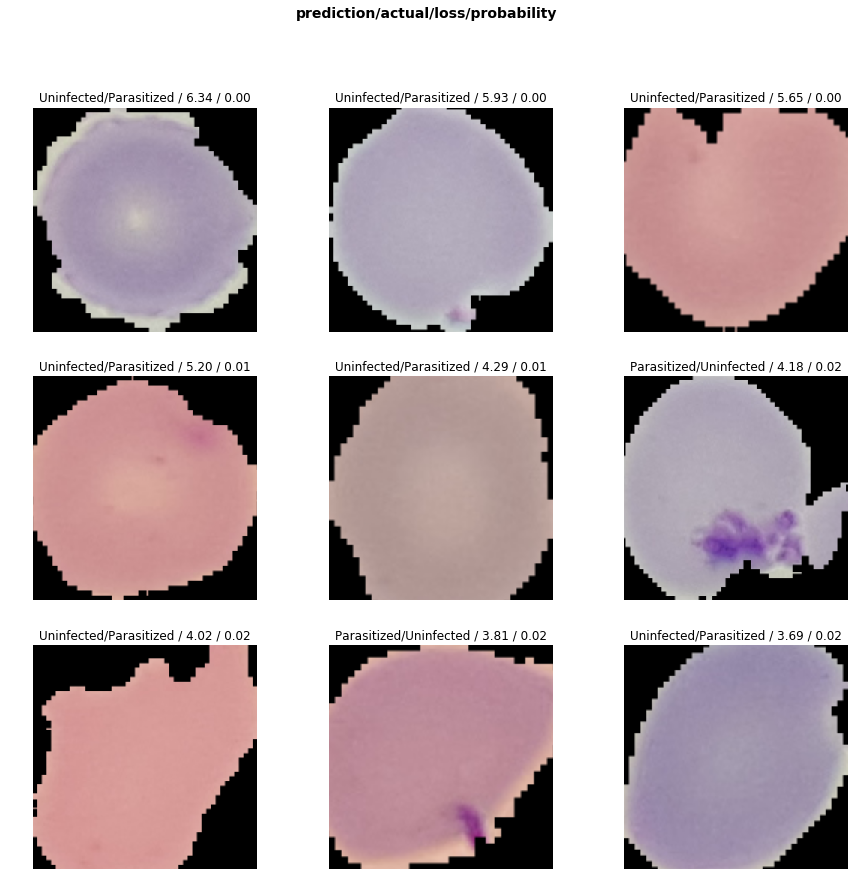

In [113]:
interp.plot_top_losses(9, figsize=(15,14), heatmap = False)

# Observation - some of these uninfected have the blob in the middle that make it look like an infected blood cell
# and vice versa. Some are clean that are labeled as infected.
# I wonder if these are mislabeled.

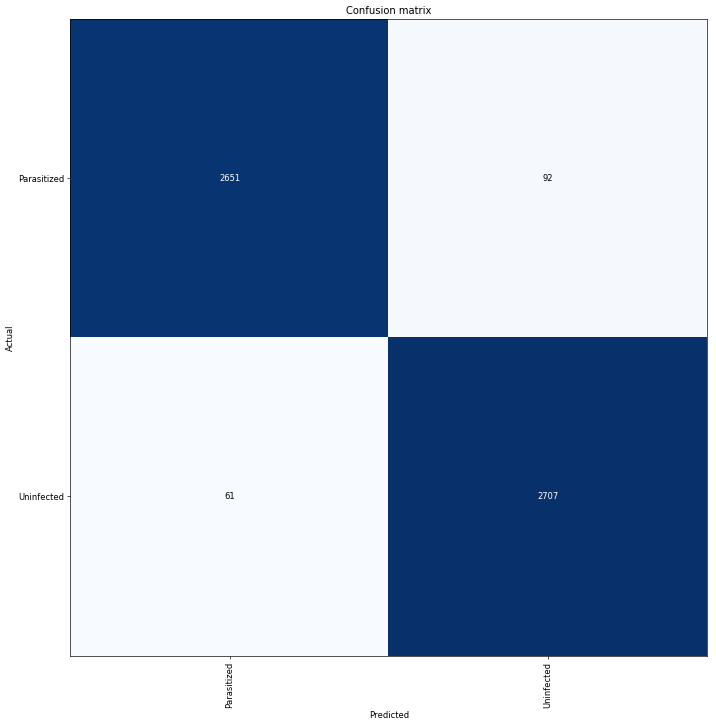

In [114]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Conclusions (for now)
- Time could have been saved if I had questioned the results more after my ResNet34 fine tuning. The ResNet50 took a day and a half after and I didn't really look at them too carefully. Sort of just ignored it because I wanted ResNet50 tuning practice. While there was slight improvement, my results could be summed up as the follow: training a 97% accurate model took 3-4 hours while adding an extra .5% accuracy took a day and a half.
- It seems that some of these images are indeed mislabeled. The most blatantly obvious ones would be the ones labeled parasitized when they are uninfected.
- The malaria infected/parasitized images in the plot_top_losses function are inconclusive. After asking several subject matter experts on Reddit there was a general hesitance to qualify an answer in either direction. Higher resolution images would be needed to draw a conclusion.
- Other more diagnostic and higher quality images were linked in the Reddit thread below. A future to-do could be to train addendums featuring said images with a slightly higher learning rate

Sources (Thanks Reddit!)
- https://www.reddit.com/r/pathology/comments/bt1dxn/im_a_data_science_student_and_i_made_a_classifier/
- https://www.reddit.com/r/medlabprofessionals/comments/bt30l2/im_a_data_science_student_and_i_made_a_classifier/